In [110]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd.variable import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Loading dataset from the file. For now, not normalized but may want to explore normalization.

In [111]:
dataset = pd.read_csv('19000-spotify-songs/cleaned_song_data.csv', index_col=0)

normalize = True

In [112]:
X = dataset.drop(labels = ['song_name', 'avg_song_popularity'], axis=1)
#Standardize to N(0, 1)
if normalize:
    X = (X - np.mean(X))/np.std(X)
X = X.values
X = torch.tensor(X).float()

In [113]:
Y = dataset['avg_song_popularity'].values
pop_mean = np.mean(Y)
pop_std = np.std(Y)
if normalize:
    Y = (Y-pop_mean)/pop_std
Y = Y[:, None]
Y = torch.tensor(Y).float()

In [114]:
X.shape, Y.shape

(torch.Size([13070, 13]), torch.Size([13070, 1]))

In [115]:
dataset = torch.utils.data.TensorDataset(X, Y)

In [116]:
validation_split = 0.30
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_split, val_split = torch.utils.data.random_split(dataset, [dataset_size - split, split])

# np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
#                                            sampler=train_sampler)
# validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                                 sampler=valid_sampler)

In [117]:
batch_size = 100
shuffle = True

train_loader = torch.utils.data.DataLoader(train_split, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_split, batch_size = split, shuffle = True)

# train_data_loader = torch.utils.data.DataLoader(dataset, 
#                                                 batch_size = batch_size,
#                                                 sampler = train_sampler)

# valid_data_loader = torch.utils.data.DataLoader(dataset,
#                                                     batch_size = batch_size,
#                                                     sampler = valid_sampler)

Architecture:

1) Input 100 x 13
2) FC with 52 units, ReLU
3) FC with 104 units, ReLU
4) FC with 52 units, ReLU
5) FC with 13 units, ReLU
6) FC with 1 unit, linear

In [195]:
class my_Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(my_Net, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_dim, in_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_dim*2, in_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_dim*4, in_dim*2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_dim*2, in_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_dim, out_dim)
        )
        

    def forward(self, x):
        return self.fc(x)

In [226]:
def train(data_loader, val_data_loader, num_epochs = 30):
        
    in_dim = next(iter(data_loader))[0].size()[1]
    out_dim = 1
    
    net = my_Net(in_dim, out_dim)
    
    #Initialize loss function & optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr = 1e-3)
    
    train_hist = {}
    train_hist['loss'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    train_hist['Validation loss'] = []
    train_hist['OSR2'] = []
    
    start_time = time.time()

    for epoch in range(num_epochs):

        epoch_start_time = time.time()

        for i, (x, y) in enumerate(data_loader, 0):
            net.train()
            batch_start_time = time.time()

            b_size = x.size()[0]

            net.zero_grad()

            x = Variable(x)
            y = Variable(y)

            output = net(x)

            loss = loss_fn(output, y)

            loss.backward()
            optimizer.step()

            train_hist['loss'].append(loss.item())

            
        with torch.no_grad():
            net.eval()
            for (x, y) in val_data_loader:
                output = net(x)
                val_MSE = loss_fn(output, y)
                train_hist['Validation loss'].append(val_MSE.item())
                r2 = r2_score(y, output)
                train_hist['OSR2'].append(r2)
                
    
        train_hist['per_epoch_time'].append(time.time() - epoch_start_time)

        train_hist['total_time'].append(time.time() - start_time)
        print("Completed epoch {}".format(epoch+1))
    return train_hist, net

In [227]:
train_hist, net = train(train_loader,val_loader, num_epochs = 100)
# valid_pred = 

Completed epoch 1
Completed epoch 2
Completed epoch 3
Completed epoch 4
Completed epoch 5
Completed epoch 6
Completed epoch 7
Completed epoch 8
Completed epoch 9
Completed epoch 10
Completed epoch 11
Completed epoch 12
Completed epoch 13
Completed epoch 14
Completed epoch 15
Completed epoch 16
Completed epoch 17
Completed epoch 18
Completed epoch 19
Completed epoch 20
Completed epoch 21
Completed epoch 22
Completed epoch 23
Completed epoch 24
Completed epoch 25
Completed epoch 26
Completed epoch 27
Completed epoch 28
Completed epoch 29
Completed epoch 30
Completed epoch 31
Completed epoch 32
Completed epoch 33
Completed epoch 34
Completed epoch 35
Completed epoch 36
Completed epoch 37
Completed epoch 38
Completed epoch 39
Completed epoch 40
Completed epoch 41
Completed epoch 42
Completed epoch 43
Completed epoch 44
Completed epoch 45
Completed epoch 46
Completed epoch 47
Completed epoch 48
Completed epoch 49
Completed epoch 50
Completed epoch 51
Completed epoch 52
Completed epoch 53
Co

Text(0.5,1,'Training loss')

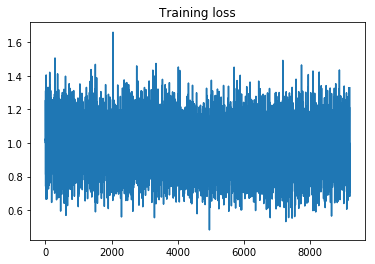

In [228]:
plt.plot(train_hist['loss'])
plt.title("Training loss")

Text(0.5,0,'Epoch')

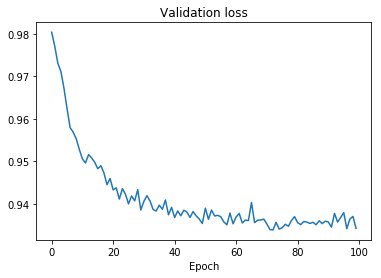

In [229]:
plt.plot(train_hist['Validation loss'])
plt.title("Validation loss")
plt.xlabel("Epoch")

Text(0.5,0,'Epoch')

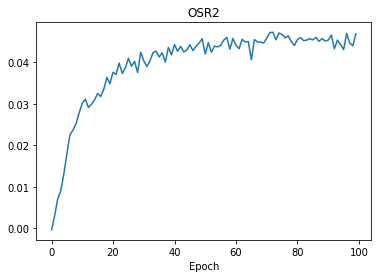

In [230]:
plt.plot(train_hist['OSR2'])
plt.title("OSR2")
plt.xlabel("Epoch")

In [231]:
np.sqrt(train_hist['Validation loss'][-1]), train_hist['OSR2'][-1]

(0.9665305955803161, 0.04682167405079429)

In [245]:
loss_fn = nn.MSELoss()
for x,y in val_loader:
    output = net(x)
    s_out = output*pop_std + pop_mean
    y_real = y * pop_std + pop_mean
#     print(output*pop_std + pop_mean, y*pop_std+pop_mean)